This notebook was used to fit a RF to an interaction that was missed in the initial run. 

In [ ]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, cross_validate
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix

In [2]:
def get_data(data_to_read):
    data = pd.read_csv(data_to_read)
    return data

def clean_data(data, determine_parents):
    data['year'] = data['year'].astype(str)
    data['block'] = data['block'].astype(str)
    
    if determine_parents:
        # We are not testing ungrafted. Remove.
        data = data[data.rootstock != 'Ungrafted']

        rupestris = []
        berlandieri = []
        riparia = []

        for row in data['rootstock']:
            if row == '1103P':
                rupestris.append('1')
                berlandieri.append('1')
                riparia.append('0')
            elif row == 'SO4':
                rupestris.append('0')
                berlandieri.append('1')
                riparia.append('1')
            elif row == '3309C':
                rupestris.append('1')
                berlandieri.append('0')
                riparia.append('1')

        print("Length rupestris: ", len(rupestris))
        print("Length berlandieri: ", len(berlandieri))
        print("Length riparia: ", len(riparia))
        data['rupestris'] = rupestris
        data['berlandieri'] = berlandieri
        data['riparia'] = riparia
    return data
    
def create_random_grid():
    # random search creation
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    return random_grid

def create_features(data, remove = 'columns'):
    # keep all the ions, imputed data
    features = data[['B', 'Na', 'Mg', 'Al','P', 'S', 'K', 'Ca', 'Fe', 'Mn', 'Co', 'Ni', 'Cu', 'Zn', 'As', 'Se', 'Rb', 'Sr', 'Mo', 'Cd']]
    return features

def create_labels(data, label1="", label2=None, interaction=False):
    if interaction:
        print(label1)
        print(label2)
        labels = data[label1] + "_" + data[label2]
        print(labels)
    else:
        labels = data[label1]
        print(type(labels))
    return labels

def print_data_info(data, model_name, labels):
    # sample size of dataframe we are using
    print(f"Model Name: {model_name}")
    print(f"Sample size: {len(data)}")

    # number of each class- csv of numbers and plot to visualize
    value_counts = labels.value_counts()
    print(f"Value Counts:\n{value_counts}")
    value_counts.to_csv(f"{model_name}_class_counts.csv")

    ax = value_counts.plot(kind='bar')
    ax.figure.savefig(f"{model_name}_class_counts.pdf", bbox_inches="tight")

def t_t_split(features, labels, model_name):
    # Train 80%, Test 20%
    # Random split, keeps label proportions similar in splits
    X_train, X_test, y_train, y_test = train_test_split(features, 
                                                      labels, 
                                                      test_size=0.20,
                                                      random_state=42,
                                                      stratify=labels)
    X_train.to_csv(f'{model_name}_X_train.csv')
    X_test.to_csv(f'{model_name}_X_test.csv')
    y_train.to_csv(f'{model_name}_y_train.csv')
    y_test.to_csv(f'{model_name}_y_test.csv')
    return X_train, X_test, y_train, y_test

def create_random_search(X_train, y_train, random_grid):
    # RandomSearchCV model for Random Forest
    rfc = RandomForestClassifier(random_state=42)
    rf_randsearch = RandomizedSearchCV(estimator=rfc,
                                       param_distributions=random_grid, 
                                       cv=5, 
                                       verbose=2, 
                                       random_state=42, 
                                       n_iter=100, 
                                       n_jobs=-1)
    return rf_randsearch

def fit_randsearch_model(X_train, y_train, rf_randsearch, model_name):
    # Fit RandomSearchCV using training data
    rf_randsearch.fit(X_train, y_train)
    # Save model
    pickle.dump(rf_randsearch, open(f'{model_name}_model.sav', 'wb'))

def get_predictions(X_test, rf_randsearch, model_name):
    # Make predictions on best estimator using test data
    predict = rf_randsearch.best_estimator_.predict(X_test)
    pd.DataFrame(predict).to_csv(f'{model_name}_predict.csv')
    return predict

def get_factors(x, y):
    # Label Factorization- For Plot Vis
    labels_factorization = {
    'rootstock_year' : ['Ungrafted_2017', '1103P_2017', '3309C_2017', 'SO4_2017', 'Ungrafted_2018', '1103P_2018', '3309C_2018', 'SO4_2018', 'Ungrafted_2019', '1103P_2019', '3309C_2019', 'SO4_2019'],
    'rootstock_phenology' : ['Ungrafted_Anthesis', '1103P_Anthesis', '3309C_Anthesis', 'SO4_Anthesis', 'Ungrafted_Veraison', '1103P_Veraison', '3309C_Veraison', 'SO4_Veraison', 'Ungrafted_Harvest', '1103P_Harvest', '3309C_Harvest', 'SO4_Harvest'],
    'rootstock_leafpos' : ['Ungrafted_X', '1103P_X', '3309C_X', 'SO4_X', 'Ungrafted_Y', '1103P_Y', '3309C_Y', 'SO4_Y', 'Ungrafted_Z', '1103P_Z', '3309C_Z', 'SO4_Z'],
    'rootstock_None' : ['Ungrafted', '1103P', '3309C', 'SO4'],
    'phenology_leafpos' : ['Anthesis_X', 'Anthesis_Y', 'Anthesis_Z', 'Veraison_X', 'Veraison_Y', 'Veraison_Z', 'Harvest_X', 'Harvest_Y', 'Harvest_Z'],
    'year_leafpos' : ['2017_X', '2017_Y', '2017_Z', '2018_X', '2018_Y', '2018_Z', '2019_X', '2019_Y', '2019_Z'],
    'year_phenology' : ['2017_Anthesis', '2017_Veraison', '2017_Harvest', '2018_Anthesis', '2018_Veraison', '2018_Harvest', '2019_Anthesis', '2019_Veraison', '2019_Harvest'],
    'year_None' : ['2017', '2018', '2019'],
    'phenology_None' : ['Anthesis', 'Veraison', 'Harvest'],
    'leafpos_None' : ['X', 'Y', 'Z'],
    'treatment_None' : ['None', 'RDI', 'Full'],
    'block_None' : ['1', '2', '3', '4', '5', '6'],
    'rupestris_None' : ['0','1'],
    'berlandieri_None' : ['0','1'],
    'riparia_None' : ['0','1']
    }
    factors = labels_factorization[f'{x}_{y}']
    return factors

def get_stats(predict, X_test, y_test, rf_randsearch, factors, ions, plot_title, model_name):
    # Confusion Matrix Statistics
    cm_stats = confusion_matrix(y_test, predict, labels=factors)
    cm_stats_normalized = normalize(cm_stats, norm="l1")
    cm_stats = pd.DataFrame(cm_stats, 
                          columns=factors, 
                          index=factors)
    cm_stats.to_csv(f"{model_name}_confusion_matrix_stats.csv")
    
    # Accuracy Score
    accuracy = accuracy_score(y_true=y_test, 
                            y_pred=predict)
    print(f"Accuracy of {model_name} is {accuracy}")

    # Classification Report
    report = classification_report(y_test, predict, 
                                 output_dict=True)
    report = pd.DataFrame(report).transpose()
    report.to_csv(f"{model_name}_classification_report.csv")
    
    # Model Best Parameters- Grid Results
    best_parameters = pd.DataFrame.from_dict(rf_randsearch.best_params_, orient='index')
    best_parameters.to_csv(f"{model_name}_chosen_parameters.csv")
    
    # Model Best Parameters- Classifier Definition
    classifier_def = repr(rf_randsearch.best_estimator_)
    with open(f'{model_name}_classifier_definition.txt', 'a') as fp:
        fp.write(classifier_def)
    
    # Model Feature Importances
    feature_importances = rf_randsearch.best_estimator_.feature_importances_
    feature_importances = pd.DataFrame(feature_importances,
                                   index=ions,
                                   columns=['importance'])
    feature_importances.to_csv(f'{model_name}_feature_importances.csv')
    
    # Model Feature Importances Chart
    feature_vis = feature_importances.plot.bar(rot=0, title=f'Feature Importances - {plot_title}')
    feature_vis.figure.savefig(f'{model_name}_feature_importances_vis.pdf', bbox_inches='tight')
    
def cross_val_feature_importances(X_train, y_train, model_name, best_params):
    rfc = RandomForestClassifier(random_state=42,
                            n_estimators = best_params['n_estimators'],
                            min_samples_split = best_params['min_samples_split'],
                            min_samples_leaf = best_params['min_samples_leaf'],
                            max_features = best_params['max_features'],
                            max_depth = best_params['max_depth'],
                            bootstrap = best_params['bootstrap'])
    output = cross_validate(rfc, X_train, y_train, cv=10, scoring='accuracy', return_estimator=True)
    
    feature_importances = pd.DataFrame(index=X_train.columns)
    for idx,estimator in enumerate(output['estimator']):
        feature_importances[idx] = estimator.feature_importances_
    feature_importances.sort_index()
    feature_importances.to_csv(f'{model_name}_feature_importances_cross_val.csv')

In [3]:
def random_forest_classification(classifications, name, data_to_read):     
    data = get_data(data_to_read)
    data = clean_data(data, determine_parents=False)
    
    # create and run and random forest model with cross validation
    random_grid = create_random_grid()
    features = create_features(data, remove=name)
    for x,y in classifications:
        if y == None:
            plot_title = f'{x}'
            interact = False
        else:
            plot_title = f'{x} {y}'
            interact = True
        
        model_name = f"{x}_{y}_{name}"
        labels = create_labels(data, x ,y, interact)
        print_data_info(data, model_name, labels)
        X_train, X_test, y_train, y_test = t_t_split(features, labels, model_name)
        rf_randsearch = create_random_search(X_train, y_train, random_grid)
        fit_randsearch_model(X_train, y_train, rf_randsearch, model_name)
        predict = get_predictions(X_test, rf_randsearch, model_name)
        factors = get_factors(x,y)
        ions = X_train.columns
        get_stats(predict, X_test, y_test, rf_randsearch, factors, ions, plot_title, model_name)
        cross_val_feature_importances(X_train, y_train, model_name, rf_randsearch.best_params_)

year
phenology
0       2017_Anthesis
1       2017_Anthesis
2       2017_Anthesis
3       2017_Anthesis
4       2017_Anthesis
            ...      
7321    2019_Veraison
7322    2019_Veraison
7323    2019_Veraison
7324    2019_Veraison
7325    2019_Veraison
Length: 7326, dtype: object
Model Name: year_phenology_bt_k10
Sample size: 7326
Value Counts:
2017_Harvest     858
2018_Harvest     851
2017_Veraison    841
2017_Anthesis    840
2018_Anthesis    835
2019_Anthesis    822
2018_Veraison    810
2019_Veraison    798
2019_Harvest     671
dtype: int64


/xfs2/millerlab/tools/conda_envs/ml_env/lib/python3.7/site-packages/ipykernel_launcher.py:87: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


/xfs2/millerlab/tools/conda_envs/ml_env/lib/python3.7/site-packages/ipykernel_launcher.py:102: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
/xfs2/millerlab/tools/conda_envs/ml_env/lib/python3.7/site-packages/ipykernel_launcher.py:103: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 285 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  6.3min finished


Accuracy of year_phenology_bt_k10 is 0.9795361527967258


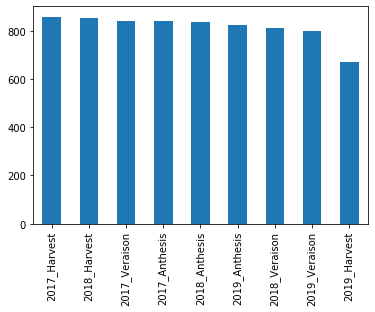

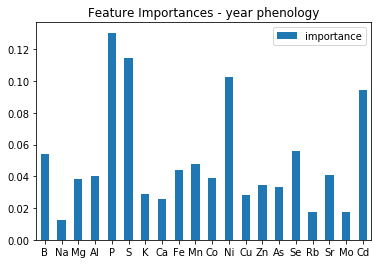

In [4]:
# these are the interactions to test
classifications = [('year', 'phenology')]

random_forest_classification(classifications, 'bt_k10', 'backtransformed_for_rf.csv')